# Machine Learning And End of Life Oil Production Forecast

### Volve is a decommissioned offshore field in the central part of the North Sea and was discovered in 1993, the plan for development and operation (PDO) was approved in 2005. The field was shut down in 2016 and the formal removal and decommissioning will be completed by the end of 2018. One important decision prior to such decommissioning is to figure out the economic cut-off date. Knowing this date will help to plan for decommissioning phase in advance and help to produce the final profitable barrels. Now, calculating such cutoff date is not easy as different structure has different operating cost profile, depending on the number and type of producing wells, product type and quality, distance to shore, water production, age, workover requirements, market prices and other related factors. There are also other criteria beyond financial ones such as environmental, socioeconomic, and health and safety considerations.

### Source: https://data-equinor-com.azurewebsites.net/dataset/volve

<h7> Shahab Athari, leading Advisor for Control and Economic Analysis in Equinor.com located in Houston, Texas.</h7> 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/matteoravasi/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load the data
path1 = ("Production_data/Volve_production_data.xlsx")
original_data = pd.read_excel(path1, thousands=',')

In [3]:
# Create a date index
original_data['DATETIME'] = pd.to_datetime(original_data['DATEPRD'])
original_data = original_data.set_index('DATETIME')
original_data = original_data.drop(['DATEPRD'], axis=1)
original_data.sort_index(inplace=True) # Sort by index time

In [4]:
# Checks column names
list(original_data.columns)

[u'WELL_BORE_CODE',
 u'NPD_WELL_BORE_CODE',
 u'NPD_WELL_BORE_NAME',
 u'NPD_FIELD_CODE',
 u'NPD_FIELD_NAME',
 u'NPD_FACILITY_CODE',
 u'NPD_FACILITY_NAME',
 u'ON_STREAM_HRS',
 u'AVG_DOWNHOLE_PRESSURE',
 u'AVG_DOWNHOLE_TEMPERATURE',
 u'AVG_DP_TUBING',
 u'AVG_ANNULUS_PRESS',
 u'AVG_CHOKE_SIZE_P',
 u'AVG_CHOKE_UOM',
 u'AVG_WHP_P',
 u'AVG_WHT_P',
 u'DP_CHOKE_SIZE',
 u'BORE_OIL_VOL',
 u'BORE_GAS_VOL',
 u'BORE_WAT_VOL',
 u'BORE_WI_VOL',
 u'FLOW_KIND',
 u'WELL_TYPE']

In [5]:
# Check the data type of each column by groupby
original_data.columns.to_series().groupby(original_data.dtypes).groups

{dtype('int64'): Index([u'NPD_WELL_BORE_CODE', u'NPD_FIELD_CODE', u'NPD_FACILITY_CODE'], dtype='object'),
 dtype('float64'): Index([u'ON_STREAM_HRS', u'AVG_DOWNHOLE_PRESSURE', u'AVG_DOWNHOLE_TEMPERATURE',
        u'AVG_DP_TUBING', u'AVG_ANNULUS_PRESS', u'AVG_CHOKE_SIZE_P',
        u'AVG_WHP_P', u'AVG_WHT_P', u'DP_CHOKE_SIZE', u'BORE_OIL_VOL',
        u'BORE_GAS_VOL', u'BORE_WAT_VOL', u'BORE_WI_VOL'],
       dtype='object'),
 dtype('O'): Index([u'WELL_BORE_CODE', u'NPD_WELL_BORE_NAME', u'NPD_FIELD_NAME',
        u'NPD_FACILITY_NAME', u'AVG_CHOKE_UOM', u'FLOW_KIND', u'WELL_TYPE'],
       dtype='object')}

In [6]:
# Count nulls
null_count = original_data.isnull().sum()
null_count[null_count>0]

ON_STREAM_HRS                285
AVG_DOWNHOLE_PRESSURE       6654
AVG_DOWNHOLE_TEMPERATURE    6654
AVG_DP_TUBING               6654
AVG_ANNULUS_PRESS           7744
AVG_CHOKE_SIZE_P            6715
AVG_CHOKE_UOM               6473
AVG_WHP_P                   6479
AVG_WHT_P                   6488
DP_CHOKE_SIZE                294
BORE_OIL_VOL                6473
BORE_GAS_VOL                6473
BORE_WAT_VOL                6473
BORE_WI_VOL                 9928
dtype: int64

In [7]:
# Fill NAs with zero
original_data = original_data.fillna(0)

In [8]:
# Drop not useful columns
original_data = original_data.drop(['NPD_FIELD_CODE','NPD_FIELD_NAME','NPD_FACILITY_CODE'], axis=1)

In [9]:
# Create cumulitive volumes
original_data['MILL_BORE_OIL_VOL_CUME']=original_data['BORE_OIL_VOL'].cumsum()* 0.000001
original_data['MILL_BORE_GAS_VOL_CUME']=original_data['BORE_GAS_VOL'].cumsum()* 0.000001
original_data['MILL_BORE_WAT_VOL_CUME']=original_data['BORE_WAT_VOL'].cumsum()* 0.000001
original_data['BOEPD_PRODUCED_VOL']= \
    (original_data['BORE_OIL_VOL']+0.05*original_data['BORE_GAS_VOL']+original_data['BORE_WAT_VOL'])
original_data['MILL_BOEPD_PRODUCED_CUME']=original_data['BOEPD_PRODUCED_VOL'].cumsum() * 0.000001

# Add a binary column showing if production BOEPD >= 3K
original_data['MIN_3K_BOEPD_BINARY'] = np.where(original_data['BOEPD_PRODUCED_VOL']  >= 3000, 1,0)

In [10]:
# Focus only the most productive well = NPD Well Bore Code 5599
#original_data = np.where(original_data['NPD_WELL_BORE_CODE']  = 3000, 1,0)
original_data = original_data[original_data['NPD_WELL_BORE_CODE'] == 5599]

In [11]:
original_data.head()

,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,...,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE,MILL_BORE_OIL_VOL_CUME,MILL_BORE_GAS_VOL_CUME,MILL_BORE_WAT_VOL_CUME,BOEPD_PRODUCED_VOL,MILL_BOEPD_PRODUCED_CUME,MIN_3K_BOEPD_BINARY
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-02-12,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,11.50,308.055940,104.418090,201.250000,18.639557,14.484431,...,385.01,0.0,production,OP,0.000285,0.038889,0.000385,2614.0935,0.002614,0
2008-02-13,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,24.00,303.033518,105.402696,182.144942,16.466641,22.832986,...,7.13,0.0,production,OP,0.002154,0.324135,0.000392,16139.1380,0.018753,1
2008-02-14,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,22.50,295.586061,105.775486,181.867887,12.659589,31.249966,...,1.16,0.0,production,OP,0.005278,0.834090,0.000393,28622.9940,0.047376,1
2008-02-15,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,23.15,297.662702,105.751875,180.832060,5.264052,28.518930,...,0.97,0.0,production,OP,0.007887,1.217516,0.000394,21780.5835,0.069157,1
2008-02-16,NO 15/9-F-12 H,5599,15/9-F-12,MÆRSK INSPIRER,24.00,295.935519,105.811114,180.501045,12.384634,30.227902,...,4.89,0.0,production,OP,0.010939,1.635990,0.000399,23980.3900,0.093137,1


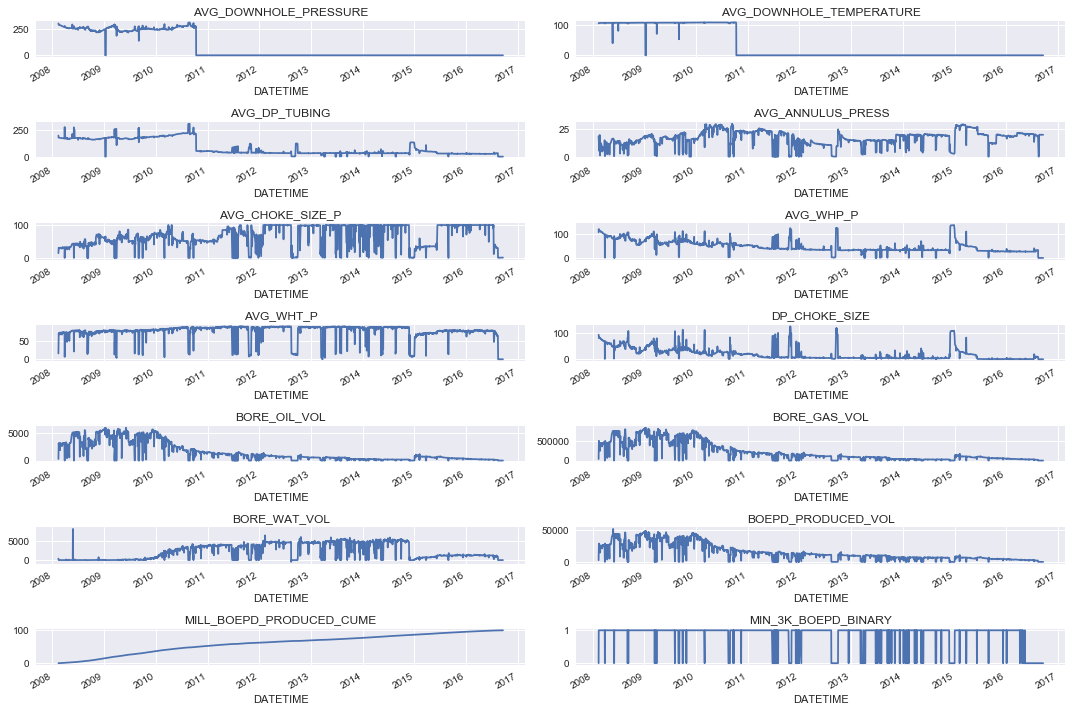

In [12]:
plt.figure(1)
plt.subplot(7,2,1)
original_data.AVG_DOWNHOLE_PRESSURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_PRESSURE') 
plt.subplot(7,2,2)
original_data.AVG_DOWNHOLE_TEMPERATURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_TEMPERATURE') 
plt.subplot(7,2,3)
original_data.AVG_DP_TUBING.plot( figsize=(15,10), title='AVG_DP_TUBING') 
plt.subplot(7,2,4)
original_data.AVG_ANNULUS_PRESS.plot( figsize=(15,10), title='AVG_ANNULUS_PRESS') 
plt.subplot(7,2,5)
original_data.AVG_CHOKE_SIZE_P.plot( figsize=(15,10), title='AVG_CHOKE_SIZE_P') 
plt.subplot(7,2,6)
original_data.AVG_WHP_P.plot( figsize=(15,10), title='AVG_WHP_P') 
plt.subplot(7,2,7)
original_data.AVG_WHT_P.plot( figsize=(15,10), title='AVG_WHT_P') 
plt.subplot(7,2,8)
original_data.DP_CHOKE_SIZE.plot( figsize=(15,10), title='DP_CHOKE_SIZE') 
plt.subplot(7,2,9)
original_data.BORE_OIL_VOL.plot( figsize=(15,10), title='BORE_OIL_VOL') 
plt.subplot(7,2,10)
original_data.BORE_GAS_VOL.plot( figsize=(15,10), title='BORE_GAS_VOL') 
plt.subplot(7,2,11)
original_data.BORE_WAT_VOL.plot( figsize=(15,10), title='BORE_WAT_VOL') 
plt.subplot(7,2,12)
original_data.BOEPD_PRODUCED_VOL.plot( figsize=(15,10), title='BOEPD_PRODUCED_VOL') 
plt.subplot(7,2,13)
original_data.MILL_BOEPD_PRODUCED_CUME.plot( figsize=(15,10), title='MILL_BOEPD_PRODUCED_CUME') 
plt.subplot(7,2,14)
original_data.MIN_3K_BOEPD_BINARY.plot( figsize=(15,10), title='MIN_3K_BOEPD_BINARY') 

plt.tight_layout()
plt.show()

In [13]:
# Creat x and y values
X=original_data[['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                 'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
                 'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']].copy()
y= original_data[['MIN_3K_BOEPD_BINARY']].copy()

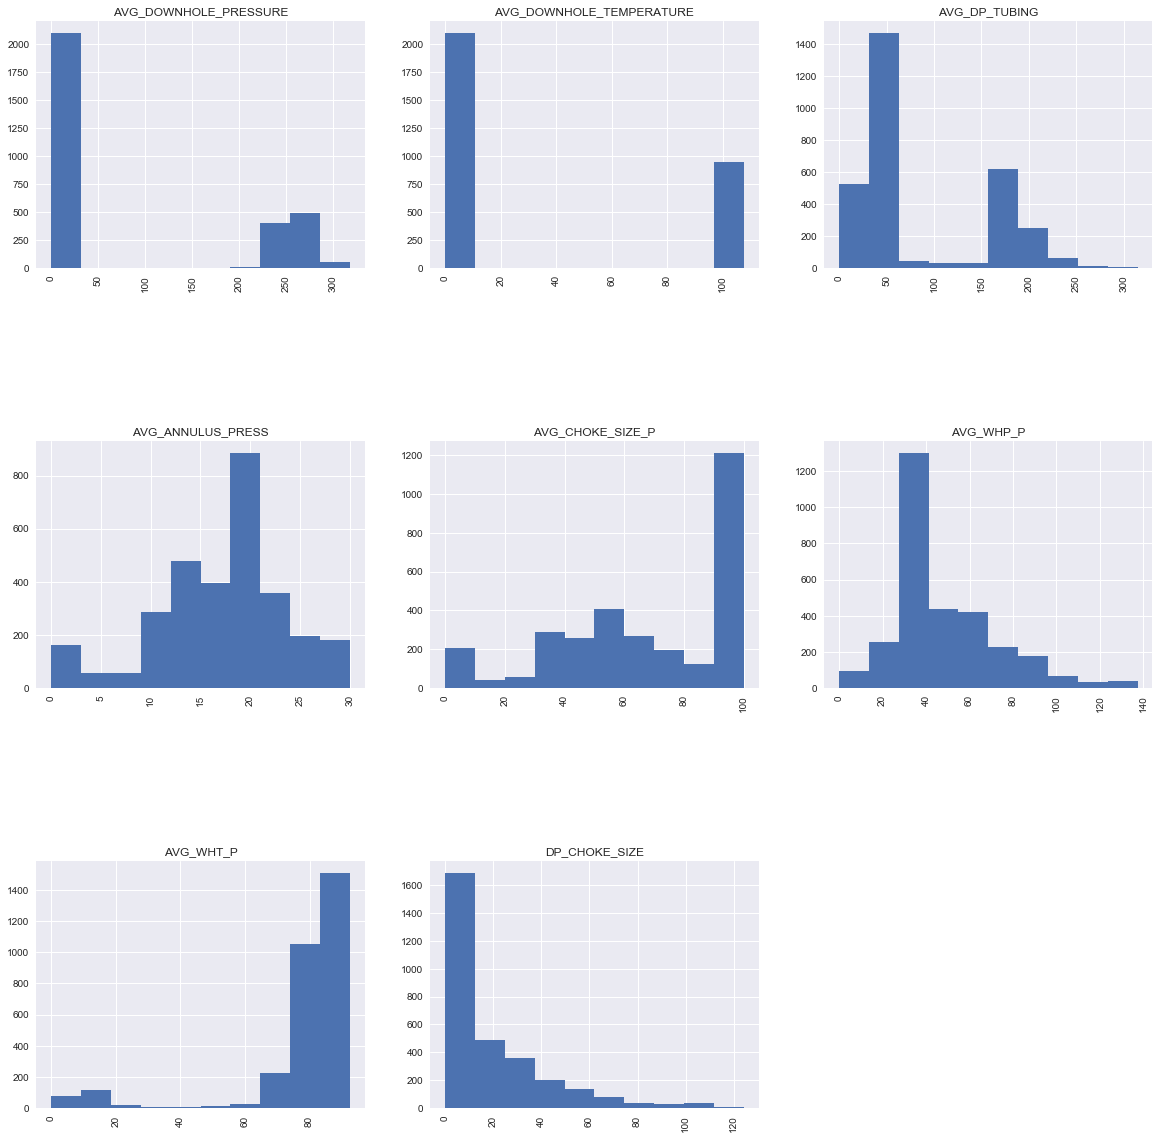

In [14]:
# Additional plot
fig = plt.figure(figsize=(20,20))
cols = 3
rows = math.ceil(float(X.shape[1]) / cols)

for i, column in enumerate(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                 'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
                 'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

In [15]:
# Create multi-step or sequence forecasting. Also, we are using some of the past observations to forecast a sequence of 
# future observations

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

x_data = series_to_supervised(X, 20)  # Including the past 20 days as new X values
x_data.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var1(t-19),var2(t-19),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-03-03,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,303.033518,105.402696,...,75.218382,74.761624,285.727865,105.910122,177.668621,10.866488,30.964472,108.059244,75.124268,74.360597
2008-03-04,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,295.586061,105.775486,...,75.124268,74.360597,285.381996,105.903653,177.306881,9.828945,30.602215,108.075115,74.280982,74.440533
2008-03-05,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,297.662702,105.751875,...,74.280982,74.440533,284.828875,105.901837,176.959589,9.322770,30.576489,107.869286,72.500005,74.262442
2008-03-06,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,295.935519,105.811114,...,72.500005,74.262442,284.294744,105.898924,176.984357,9.113610,30.588812,107.310387,75.002263,73.374819
2008-03-07,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,295.551657,105.831299,...,75.002263,73.374819,284.423682,105.878153,176.669994,6.275874,28.824959,107.753688,71.041615,73.568443


In [16]:
y_data = series_to_supervised(y,20)  # Adjusting y with recent past 20 days actual data
y_data.head()

,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2008-03-03,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2008-03-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2008-03-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2008-03-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2008-03-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [17]:
y_data = y_data.loc[:,'var1(t)'] # Eliminate other time-series steps for y lables as they need to beed 1D

In [18]:
y_data.head()

DATETIME
2008-03-03    1
2008-03-04    1
2008-03-05    1
2008-03-06    1
2008-03-07    1
Name: var1(t), dtype: int64

In [19]:
x_data.shape, y_data.shape # Check to make sure dimensions are right size

((3036, 168), (3036,))

In [26]:
from sklearn.model_selection import train_test_split

# Spliting into 70% for training set and 30% for testing set so we can see our accuracy
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [27]:
from sklearn.svm import SVC   
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Declaring the SVC with a linear classifier (also known as a maximum margin classifier) and cost value as 1.0:
    
classifier = SVC(kernel='linear',C=1.,random_state=4)

# Fitting the data. This is where the SVM will learn
classifier.fit(X_train, y_train.values)

# Predicting the result and giving the accuracy
score = classifier.score(X_test, y_test.values)

print(score)

0.930845225027


In [28]:
print ("\nLinear Classifier - Train Confusion Matrix\n\n%s" % pd.crosstab(y_train, classifier.predict(X_train),rownames = ["Actuall"],colnames = ["Predicted"]) )      
print("\n##############################################")
print ("\Linear Classifier - Train accuracy:",accuracy_score(y_train, classifier.predict(X_train))) 
print("\n##############################################")
print ('Linear Classifier - Train Classification Report\n%s' % classification_report(y_train,classifier.predict(X_train))) 
print("\n##############################################")


Linear Classifier - Train Confusion Matrix

Predicted    0     1
Actuall             
0          275     7
1            8  1835

##############################################
('\\Linear Classifier - Train accuracy:', 0.99294117647058822)

##############################################
Linear Classifier - Train Classification Report
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       282
          1       1.00      1.00      1.00      1843

avg / total       0.99      0.99      0.99      2125


##############################################


In [29]:
print ("\nLinear Classifier - Test Confusion Matrix\n\n%s" % pd.crosstab(y_test, classifier.predict(X_test),rownames = ["Actuall"],colnames = ["Predicted"]) )      
print("\n##############################################")
print ("\Linear Classifier - Test accuracy:",accuracy_score(y_test, classifier.predict(X_test))) 
print("\n##############################################")
print ('Linear Classifier - Test Classification Report\n%s' % classification_report(y_test,classifier.predict(X_test))) 
print("\n##############################################")


Linear Classifier - Test Confusion Matrix

Predicted   0    1
Actuall           
0          87   21
1          42  761

##############################################
('\\Linear Classifier - Test accuracy:', 0.93084522502744238)

##############################################
Linear Classifier - Test Classification Report
             precision    recall  f1-score   support

          0       0.67      0.81      0.73       108
          1       0.97      0.95      0.96       803

avg / total       0.94      0.93      0.93       911


##############################################


### F1 score of 0.87 indicates a high weighted average of the precision and recall. Also, the best F1 score is 1 and worst score is 0. This means there is considerable prediction power in recent production history that can be leveraged when forecasting future. Such predicative model combined with similar ones on market prices and other end-of-life criteria (e.g. HSE,  project schdule and similar) can help to minimize the total financial burden of the decommissioning phase of a platform.  

### There are much more dataset about Volve that should be explored along with these data. Training different algorithm using Volve data can be quite useful for many of NCS aging platforms expected to go through similar decommissioning phase in near future.